# Predicting the House Prices using XGBoost ensemble model.
### [Link to the Kaggle Competition](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)

## 1. Downloading the data and getting insights.

In [1]:
import pandas as pd

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


We can drop the 'Id' column right away as it doesn't give us any information.

In [3]:
df_train.drop('Id', axis=1, inplace=True)
df_test.drop('Id', axis=1, inplace=True)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

As we can see, our dataset contains a lot of null values, as well as many columns of 'object' type. So, the data should be **imputed** and **encoded** first.
Let's delete 'PoolQC' feature now as it contains only 7 non-null values and seems to be useless to us.

In [5]:
df_train.drop('PoolQC', axis=1, inplace=True)
df_test.drop('PoolQC', axis=1, inplace=True)

Let's plot the histogram for each attribute to identify **outliers**.

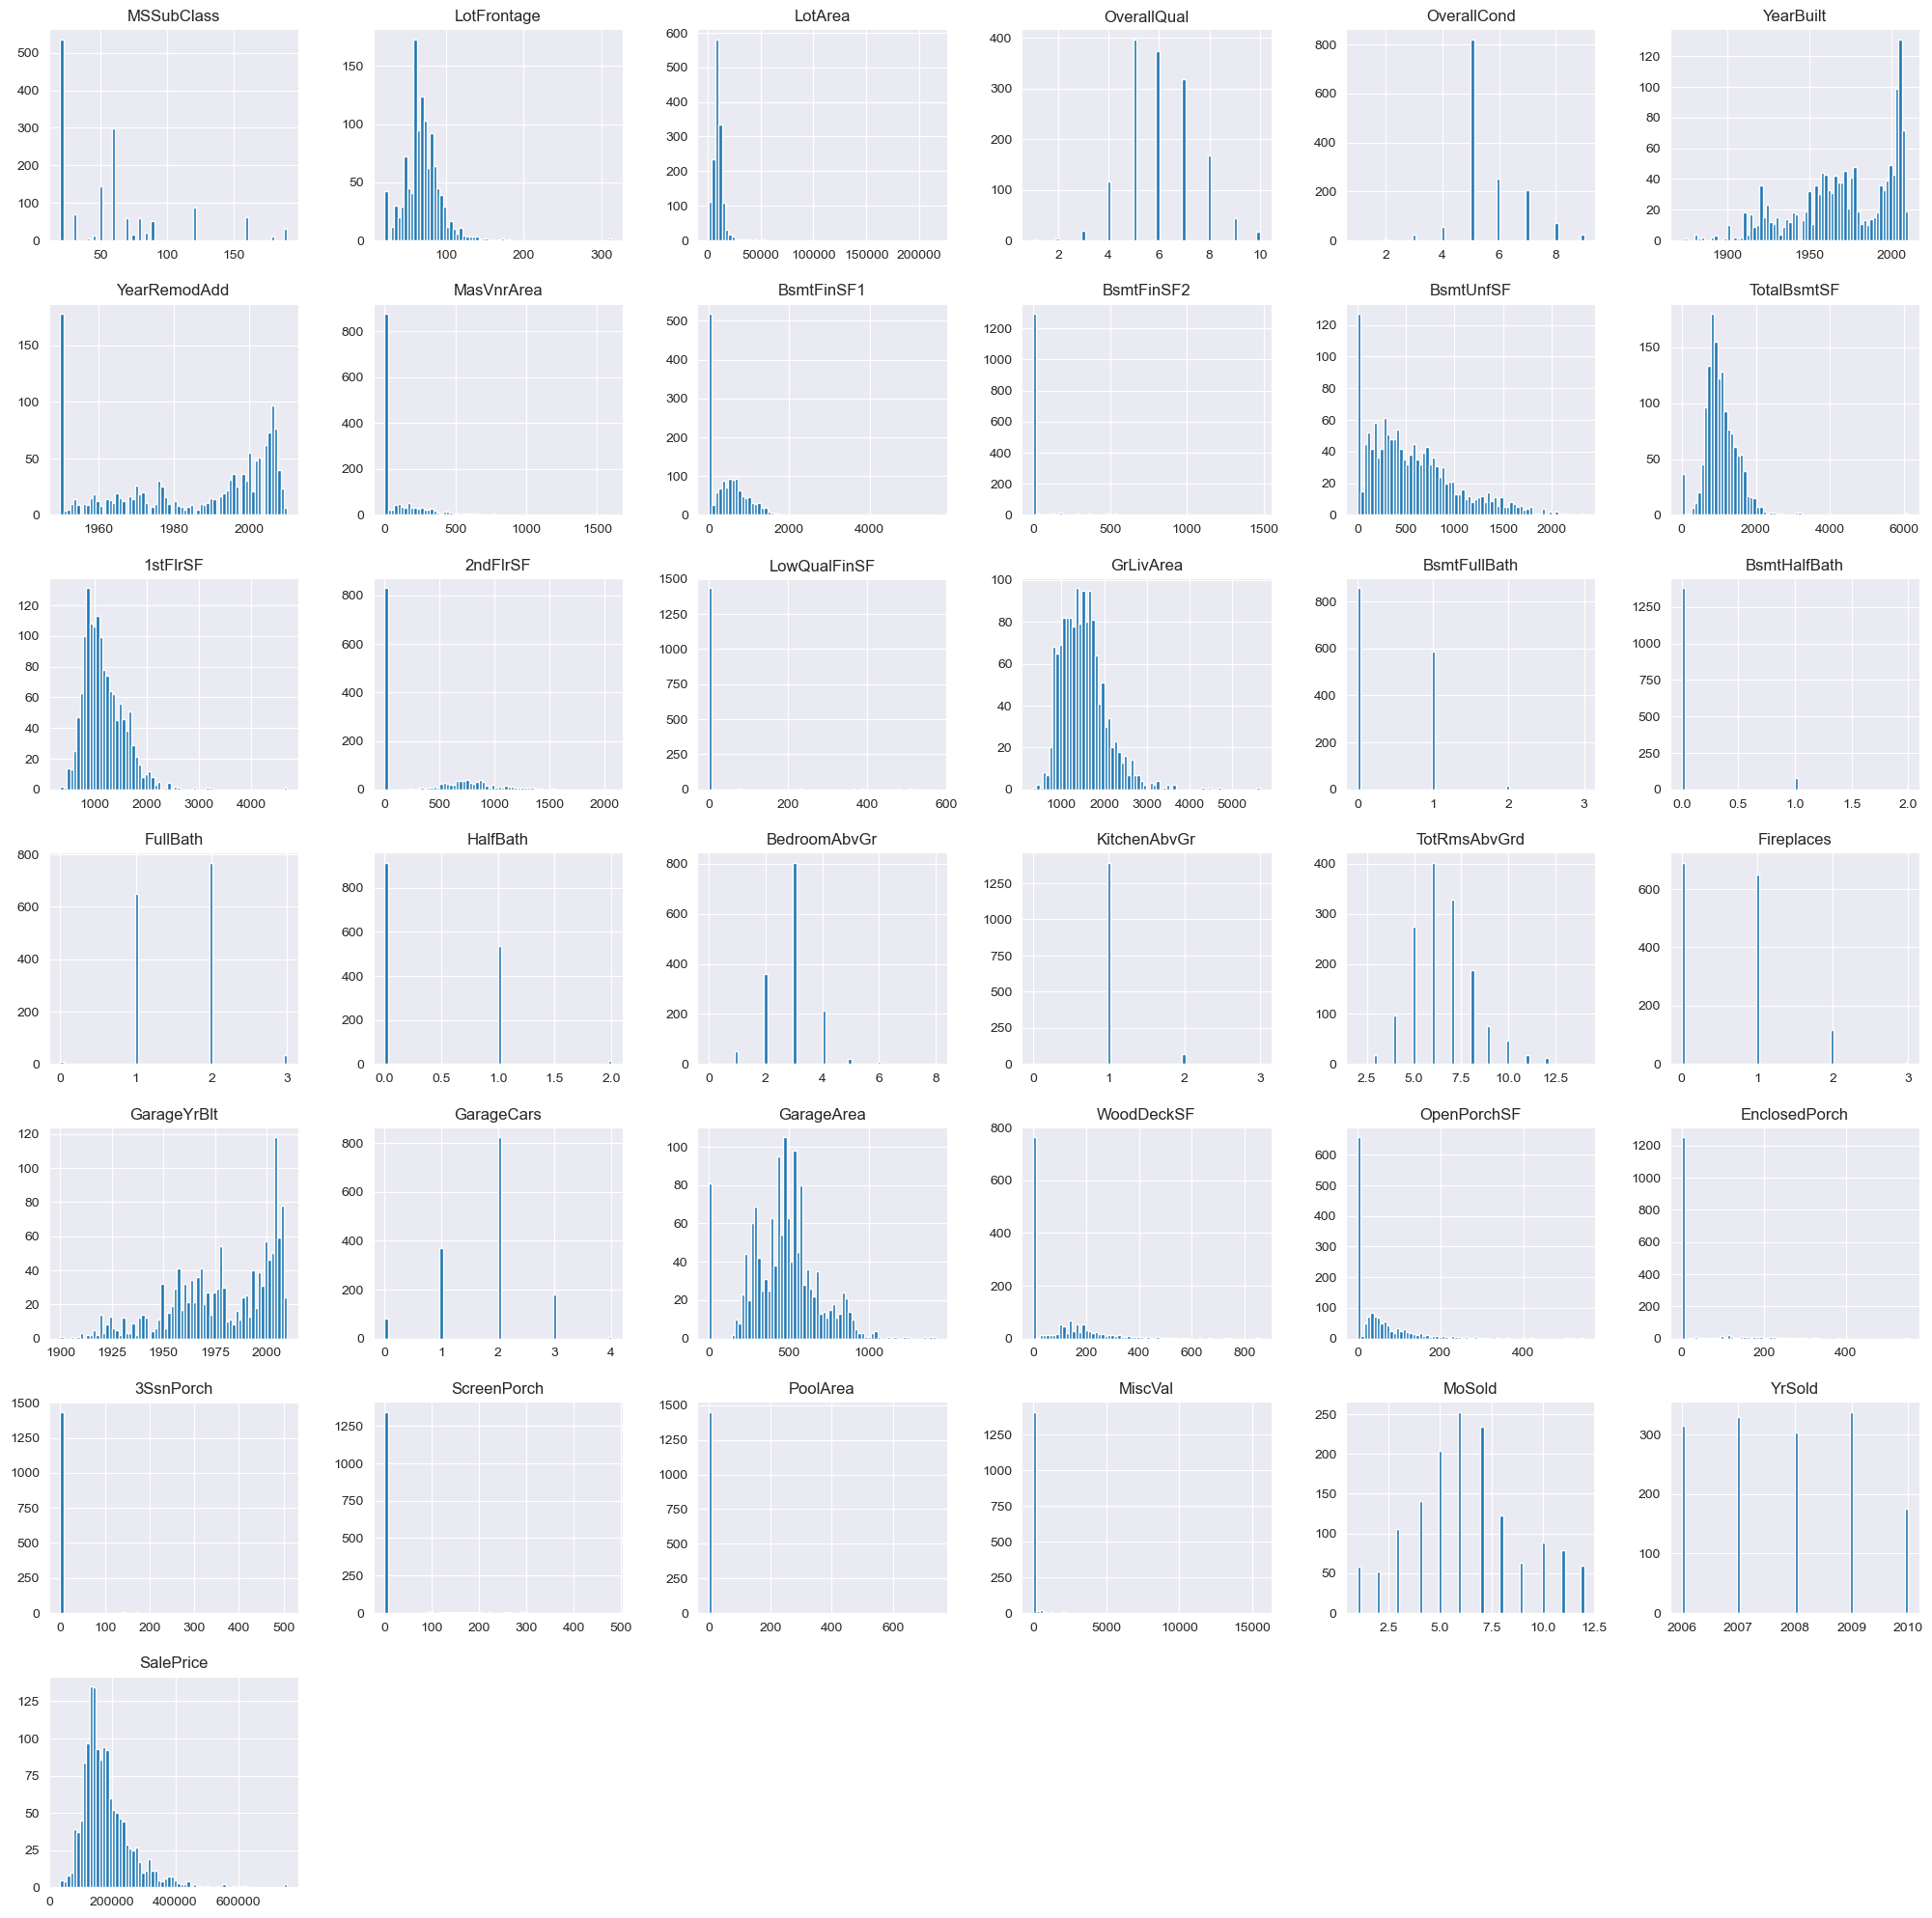

In [6]:
import matplotlib.pyplot as plt

df_train.hist(bins=70, figsize=(25, 25))
plt.show()

From the plots, it is clear that some attributes(LotFrontage, OpenPorchSF, etc.) contain outliers. They should be also **excluded** to avoid ambiguity.

## 2. Splitting the data.
It is important to split the data **before** preprocessing. Otherwise, the model can perform 'better' on provided data because of **data leakage**.

In [7]:
X_train, y_train = df_train.drop('SalePrice', axis=1), df_train.SalePrice
X_test = df_test.copy()

## 3. Visualizing the data and understanding correlations.

We can build a plot of correlation matrix to understand which features are highly correlated. Such features would be removed to exclude bias.

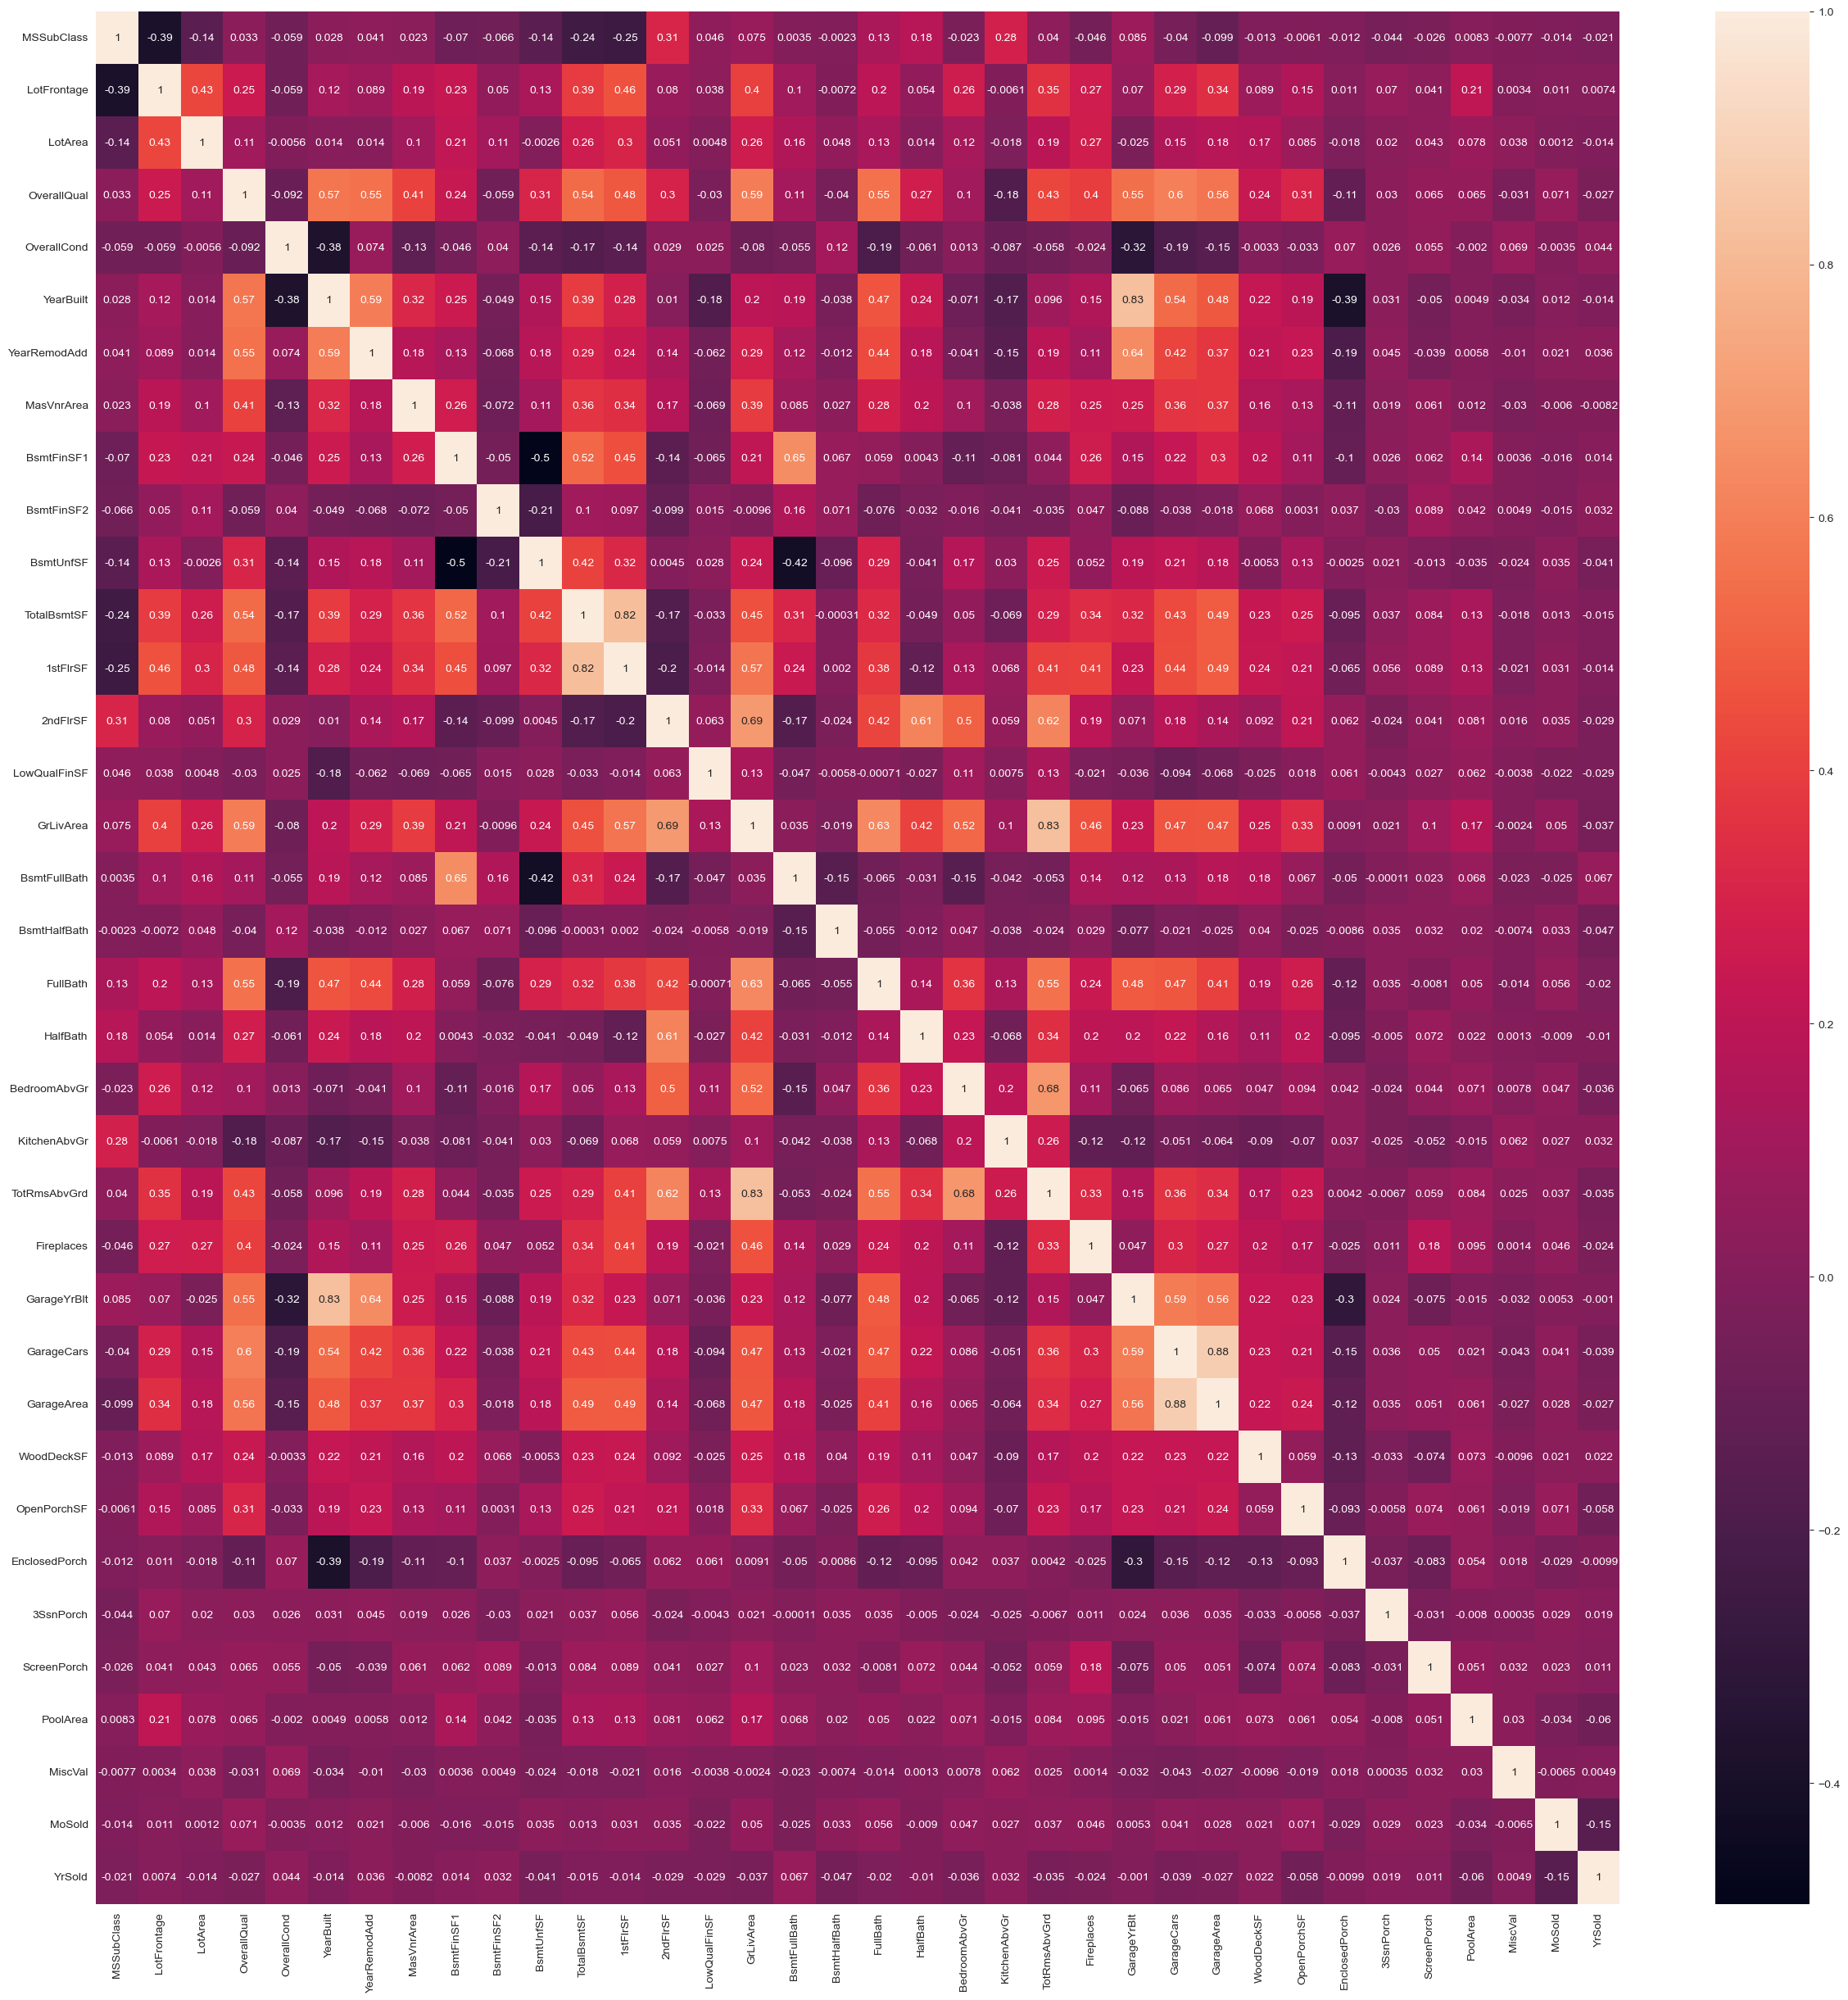

In [8]:
import seaborn as sns

plt.figure(figsize=(30, 30))
sns.heatmap(X_train.corr(numeric_only=True), annot=True)
plt.show()

### Some conclusions from plot:
1. **GarageYrBlt** is almost the same as **YearBuilt**. Garages are almost always built together with the house.
2. **TotRmsAbvGrd** and **GrLivArea** carry the same information. One of them can be removed.
3. **GarageCars** feature is redundant because **GarageArea** feature contains the correlated value.
4. The same applies for columns **TotalBsmtSF** and **1stFlrSF** - they have the same meaning.

It is interesting to note that data contains a few negative correlations, however they are all weak.

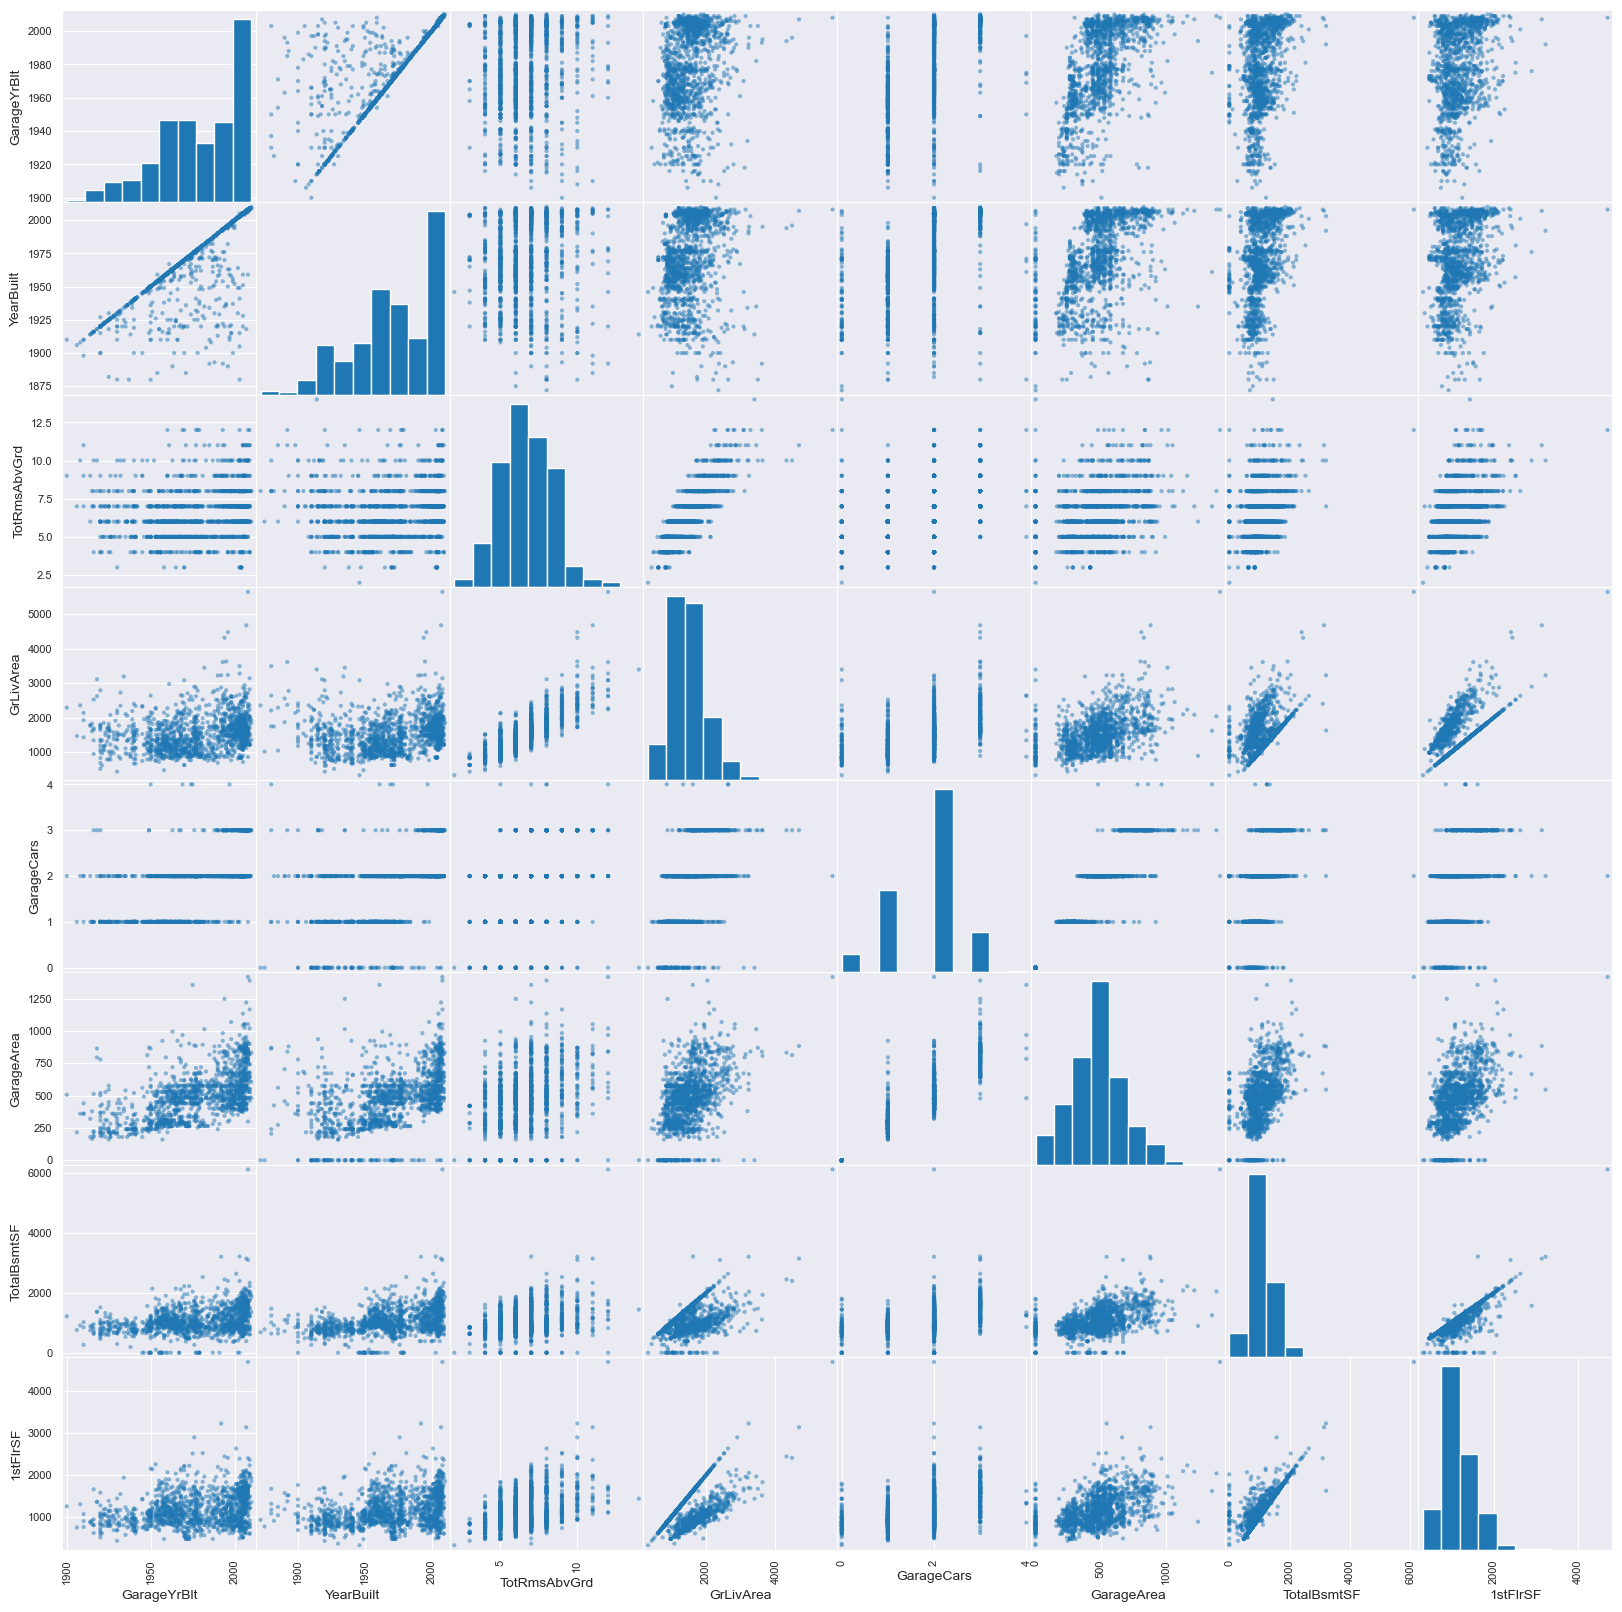

In [9]:
from pandas.plotting import scatter_matrix

attributes = ['GarageYrBlt', 'YearBuilt', 'TotRmsAbvGrd', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
              '1stFlrSF']
scatter_matrix(X_train[attributes], figsize=(20, 20))
plt.show()

Scatter plot of suspected columns also shows the high dependency between them.

## 4. Preprocessing the data.

### 1) Removing correlated features.

In [10]:
correlated_features = ['GarageYrBlt', 'TotRmsAbvGrd', 'GarageCars', '1stFlrSF']

X_train_clear = X_train.drop(correlated_features, axis=1)
X_test_clear = X_test.drop(correlated_features, axis=1)

print("Number of columns left:", len(X_train_clear.columns))

Number of columns left: 74


### 2) Excluding outliers.

In [11]:
columns_with_outliers = ['LotFrontage', 'TotalBsmtSF', 'OpenPorchSF', 'GarageArea', 'GrLivArea', 'LotArea',
                         'WoodDeckSF']

for col in columns_with_outliers:
    low_value = X_train_clear[col].quantile(0.01)
    high_value = X_train_clear[col].quantile(0.99)

    y_train = y_train[(X_train_clear[col] > low_value) & (X_train_clear[col] < high_value)]
    X_train_clear = X_train_clear[(X_train_clear[col] > low_value) & (X_train_clear[col] < high_value)]
    X_test_clear = X_test_clear[(X_test_clear[col] > low_value) & (X_test_clear[col] < high_value)]

Let's plot the histograms to ensure that outliers are gone.

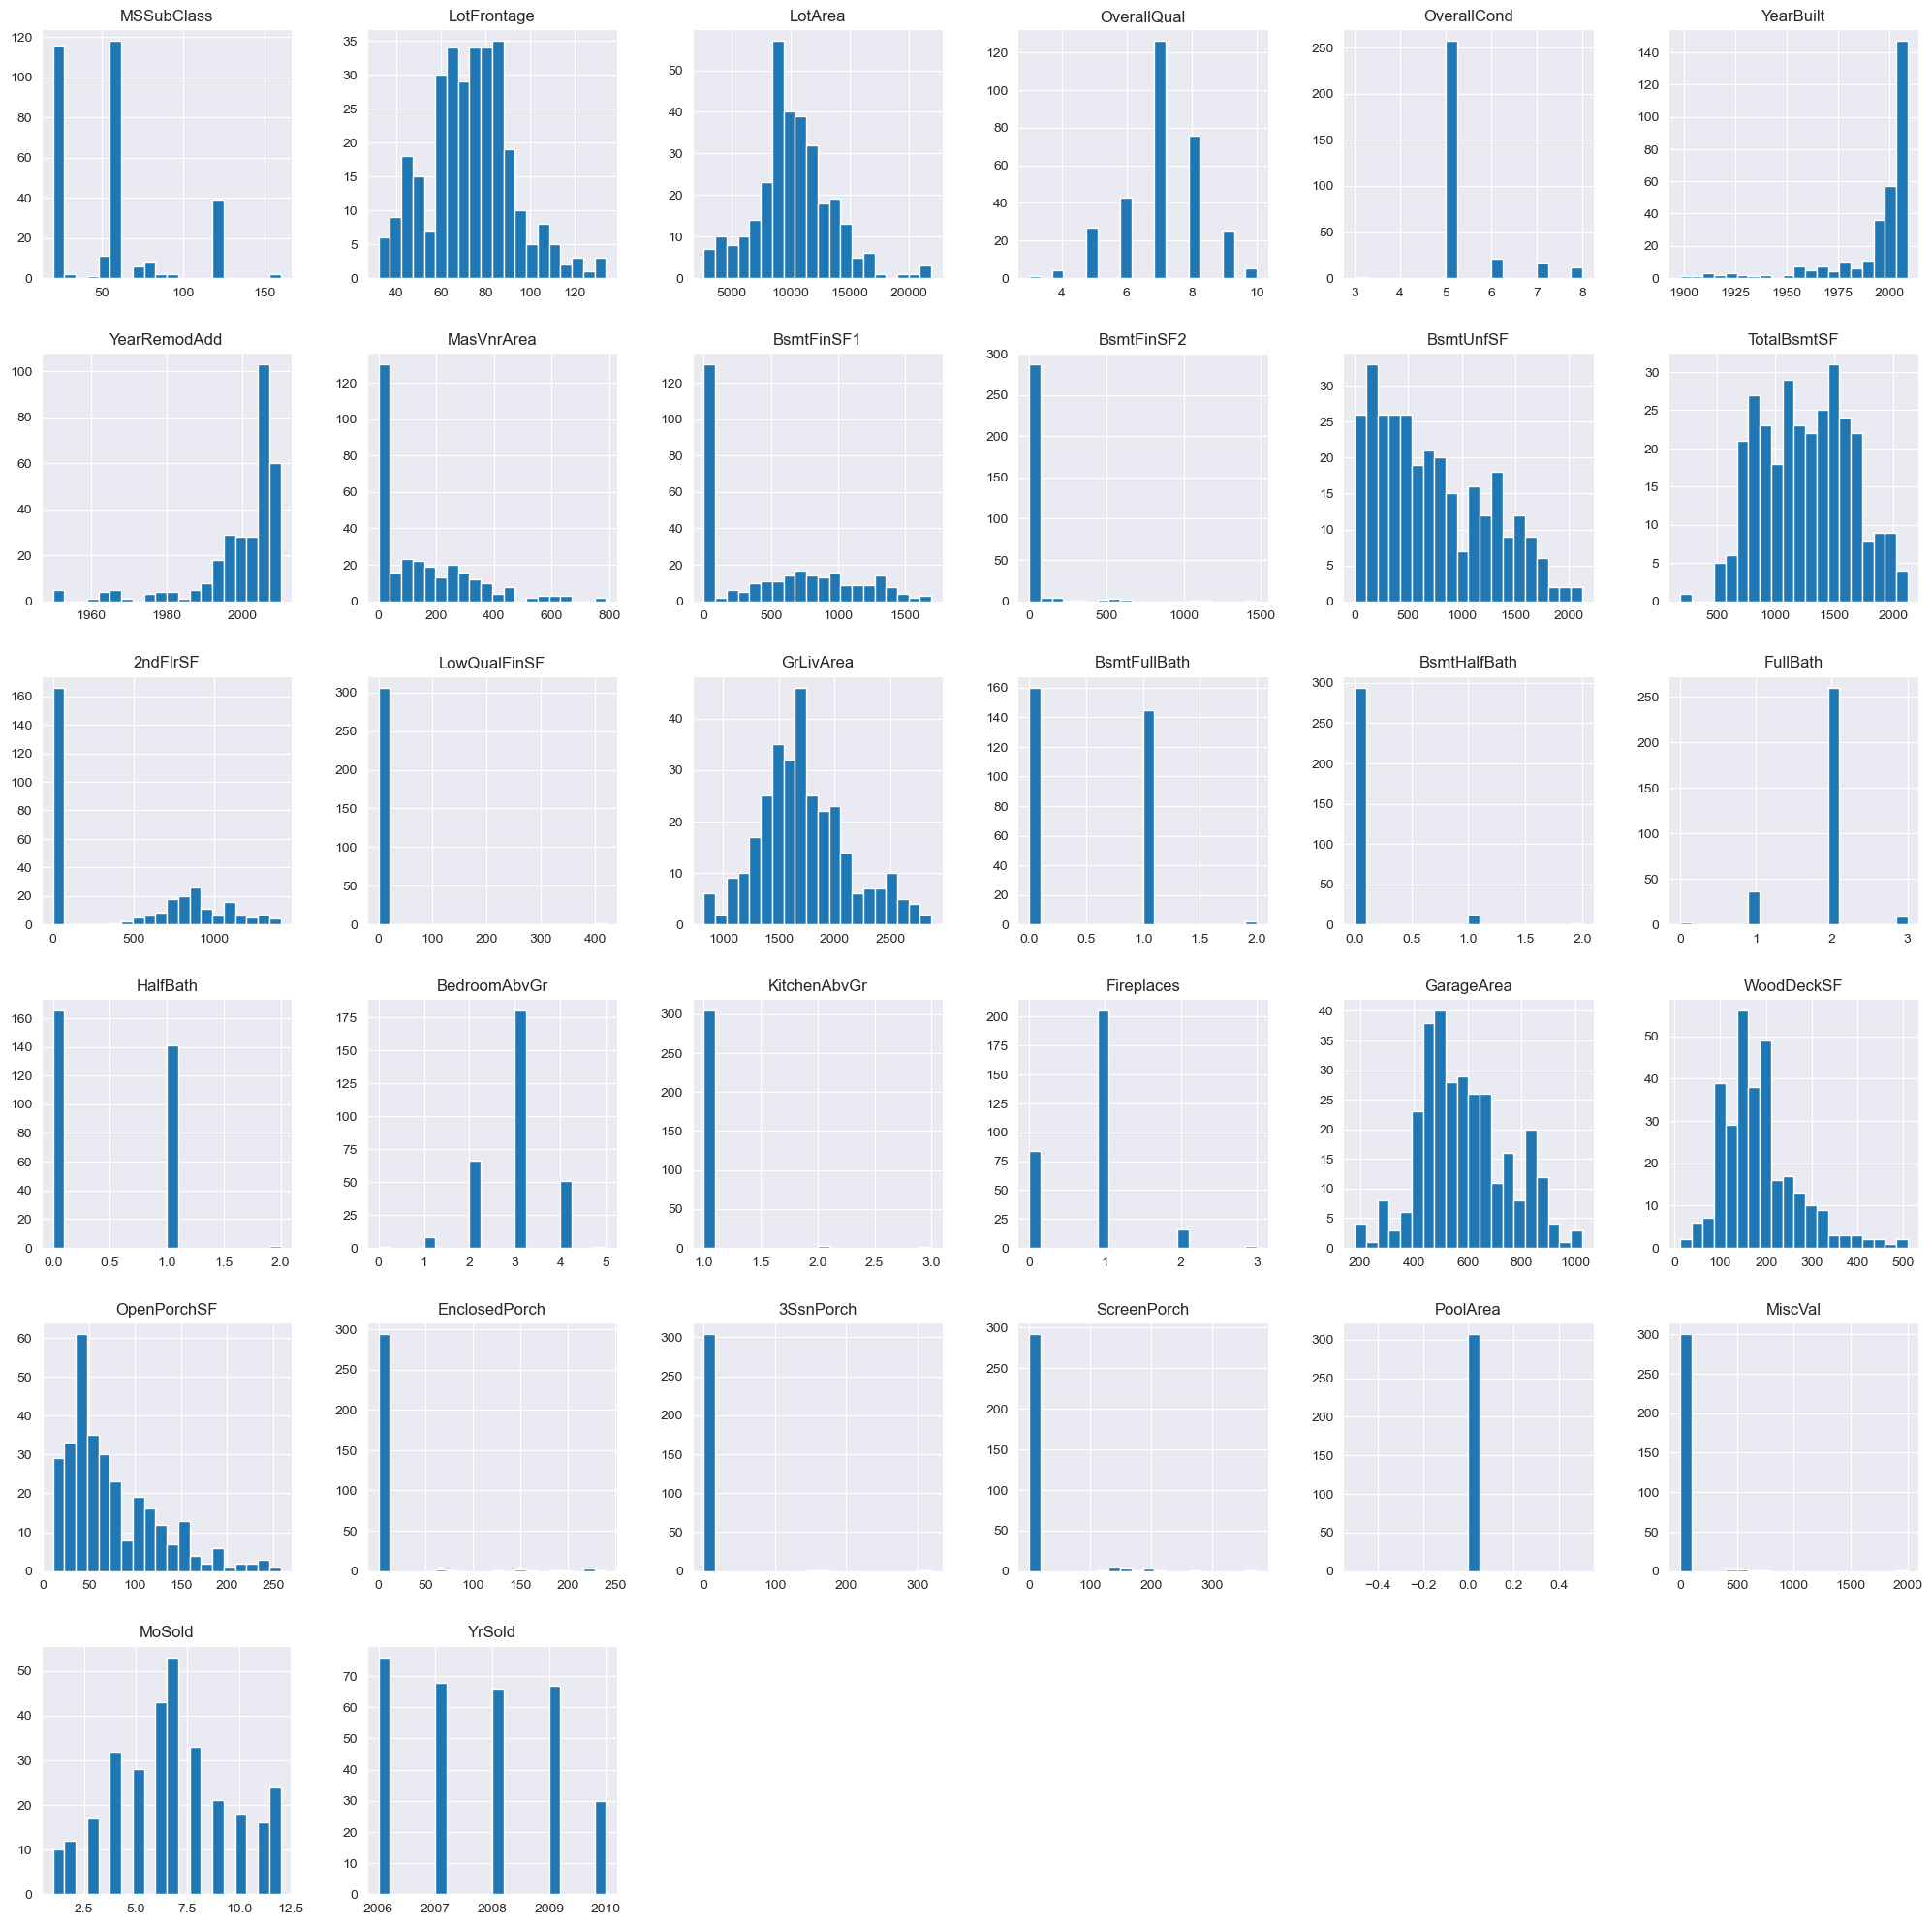

In [12]:
X_train_clear.hist(bins=20, figsize=(25, 25))
plt.show()

### 3) Imputing missing values.

In [13]:
def impute_missing_values(data: pd.DataFrame) -> pd.DataFrame:
    """Imputes all columns using 'most_frequent' strategy for object features and 'median' strategy for numeric features.

    :param data: pandas DataFrame to impute
    :return: imputed pandas DataFrame
    """

    object_null_cols = data.select_dtypes('object').isna().columns
    numeric_null_cols = data.select_dtypes('number').isna().columns

    object_imputer = SimpleImputer(strategy='most_frequent')
    object_data = pd.DataFrame(object_imputer.fit_transform(data[object_null_cols]), columns=object_null_cols)

    number_imputer = SimpleImputer(strategy='median')
    number_data = pd.DataFrame(number_imputer.fit_transform(data[numeric_null_cols]), columns=numeric_null_cols)

    return pd.concat([object_data, number_data], axis=1)

In [14]:
from sklearn.impute import SimpleImputer

X_train_imp = impute_missing_values(X_train_clear)
X_test_imp = impute_missing_values(X_test_clear)

X_train_imp.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,RL,Pave,Grvl,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0
1,RL,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,480.0,40.0,30.0,0.0,320.0,0.0,0.0,700.0,10.0,2009.0
2,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,...,636.0,255.0,57.0,0.0,0.0,0.0,0.0,0.0,8.0,2007.0
3,RL,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,...,736.0,147.0,21.0,0.0,0.0,0.0,0.0,0.0,7.0,2006.0
4,RL,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,840.0,160.0,33.0,0.0,0.0,0.0,0.0,0.0,8.0,2007.0


Let's check that there is no data missing.

In [15]:
print("Number of missing values:", X_train_imp.isna().sum().max() + X_test_imp.isna().sum().max())

Number of missing values: 0


### 4) Encoding the categorical features.
Firstly, let's drop categorical features, which represent almost the same things.

In [16]:
features_to_drop = ['Alley', 'LotShape', 'Condition2', 'RoofStyle', 'Exterior2nd']

X_train_imp.drop(features_to_drop, axis=1, inplace=True)
X_test_imp.drop(features_to_drop, axis=1, inplace=True)

X_train_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 69 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       307 non-null    object 
 1   Street         307 non-null    object 
 2   LandContour    307 non-null    object 
 3   Utilities      307 non-null    object 
 4   LotConfig      307 non-null    object 
 5   LandSlope      307 non-null    object 
 6   Neighborhood   307 non-null    object 
 7   Condition1     307 non-null    object 
 8   BldgType       307 non-null    object 
 9   HouseStyle     307 non-null    object 
 10  RoofMatl       307 non-null    object 
 11  Exterior1st    307 non-null    object 
 12  MasVnrType     307 non-null    object 
 13  ExterQual      307 non-null    object 
 14  ExterCond      307 non-null    object 
 15  Foundation     307 non-null    object 
 16  BsmtQual       307 non-null    object 
 17  BsmtCond       307 non-null    object 
 18  BsmtExposu

We can observe the categories of ordinal features from the 'data_description.txt' file.

In [17]:
categories = {
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'FireplaceQu': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish': ['Unf', 'RFn', 'Fin'],
    'GarageQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['MnWw', 'GdWo', 'MnPrv', 'GdPrv']
}

In [18]:
def ordinal_encode(data: pd.DataFrame) -> pd.DataFrame:
    """Encodes the ordinal columns in provided data.

    :param data: pandas DataFrame with columns to encode
    :return: encoded pandas DataFrame
    """

    ord_encoder = OrdinalEncoder(categories=list(categories.values()))
    encoded_ord_features = pd.DataFrame(ord_encoder.fit_transform(data[categories.keys()]), columns=categories.keys())
    data.drop(categories.keys(), axis=1, inplace=True)
    data = pd.concat([data, encoded_ord_features], axis=1)

    return data


def one_hot_encode(data: pd.DataFrame) -> pd.DataFrame:
    """Encodes the nominal columns in provided data.

    :param data: pandas DataFrame with columns to encode
    :return: encoded pandas DataFrame
    """

    nom_data = data.select_dtypes('object')

    oh_encoder = OneHotEncoder(sparse_output=False)
    encoded_nom_features = pd.DataFrame(oh_encoder.fit_transform(nom_data),
                                        columns=oh_encoder.get_feature_names_out(nom_data.columns))
    data = pd.concat([data, encoded_nom_features], axis=1)
    data.drop(nom_data.columns, axis=1, inplace=True)

    return data

In [19]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

X_train_encoded = one_hot_encode(ordinal_encode(X_train_imp))
X_test_encoded = one_hot_encode(ordinal_encode(X_test_imp))

X_train_encoded.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLw,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,50.0,85.0,14115.0,5.0,5.0,1993.0,1995.0,0.0,732.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,20.0,75.0,10084.0,8.0,5.0,2004.0,2005.0,186.0,1369.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,60.0,85.0,11924.0,9.0,5.0,2005.0,2006.0,286.0,998.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,20.0,91.0,10652.0,7.0,5.0,2006.0,2007.0,306.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### Now our data is well-prepared for XGBoost model!

In [20]:
X_train = X_train_encoded
X_test = X_test_encoded

## 5. Training a naive model.
Let's explore how well the model performs with the default parameters. We will cross validation on train data.

In [21]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

xgb_reg = XGBRegressor()

cross_val_score(estimator=xgb_reg, X=X_train, y=y_train, n_jobs=-1, cv=10).max()

0.9017402983877337

The result is not bad, but let's check the metrics...

In [22]:
def print_metrics(y_actual, y_pred):
    mse = metrics.mean_squared_error(y_actual, y_pred)
    print("MSE:", mse)
    print("RMSE:", np.sqrt(mse))
    print("MAE:", metrics.mean_absolute_error(y_actual, y_pred))
    print("R2 Score:", metrics.r2_score(y_actual, y_pred))

In [23]:
from sklearn import metrics
import numpy as np

xgb_reg.fit(X_train, y_train)
print_metrics(y_train, xgb_reg.predict(X_train))

MSE: 3200.558232111729
RMSE: 56.573476401152234
MAE: 37.36983407980456
R2 Score: 0.999999413465988


Looking at the R2 score, it seems that the model is **overfitting** too much. Also, we can check the **feature importances**.

<Figure size 3000x3000 with 0 Axes>

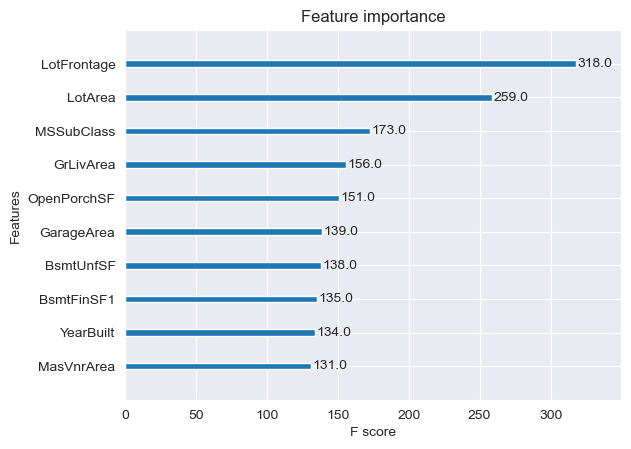

In [24]:
import xgboost as xgb

plt.figure(figsize=(30, 30))
xgb.plot_importance(xgb_reg, max_num_features=10)
plt.show()

Looks strange, these features should not affect the model so much...
Let's **tune the hyperparameters** to improve our predictions.

## 6. Tuning the hyperparameters.

In [27]:
from sklearn.model_selection import GridSearchCV

tuning_parameters = {
    'max_depth': range(3, 10),
    'gamma': np.linspace(1, 9, 5),
    'reg_alpha': range(40, 180, 10),
    'reg_lambda': np.linspace(0, 1, 5)
}

grid_search = GridSearchCV(estimator=XGBRegressor(), param_grid=tuning_parameters, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 2450 candidates, totalling 12250 fits
[CV] END gamma=1.0, max_depth=3, reg_alpha=40, reg_lambda=0.0; total time=   0.1s
[CV] END gamma=1.0, max_depth=3, reg_alpha=40, reg_lambda=0.5; total time=   0.1s
[CV] END gamma=1.0, max_depth=3, reg_alpha=40, reg_lambda=0.75; total time=   0.1s
[CV] END gamma=1.0, max_depth=3, reg_alpha=50, reg_lambda=0.0; total time=   0.1s
[CV] END gamma=1.0, max_depth=3, reg_alpha=50, reg_lambda=0.25; total time=   0.1s
[CV] END gamma=1.0, max_depth=3, reg_alpha=50, reg_lambda=0.75; total time=   0.1s
[CV] END gamma=1.0, max_depth=3, reg_alpha=50, reg_lambda=1.0; total time=   0.1s
[CV] END gamma=1.0, max_depth=3, reg_alpha=60, reg_lambda=0.25; total time=   0.1s
[CV] END gamma=1.0, max_depth=3, reg_alpha=60, reg_lambda=0.5; total time=   0.1s
[CV] END gamma=1.0, max_depth=3, reg_alpha=60, reg_lambda=1.0; total time=   0.1s
[CV] END gamma=1.0, max_depth=3, reg_alpha=70, reg_lambda=0.0; total time=   0.1s
[CV] END gamma=1.0, max_dept

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': array([1., 3., 5., 7., 9.]),
                         'max_depth': range(3, 10),
                         'reg_alpha': range(40, 180, 10),
                         'reg_lambda': array([0.  , 0.25, 0.5 , 0.75, 1.  ])},
             scoring='neg_mean_squared_error', verbose=2)

In [38]:
y_pred = grid_search.best_estimator_.predict(X_train)
print_metrics(y_train, y_pred)

MSE: 12238660.730144488
RMSE: 3498.379729266748
MAE: 2582.9271427117264
R2 Score: 0.9977571441418589


Looks promising! What about feature importances?

<Figure size 3000x3000 with 0 Axes>

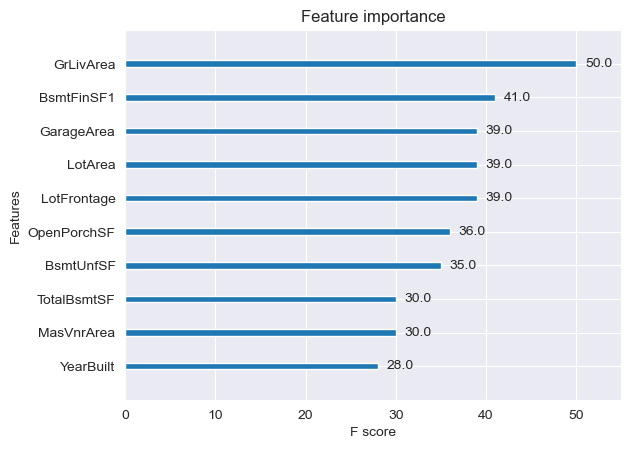

In [39]:
plt.figure(figsize=(30, 30))
xgb.plot_importance(grid_search.best_estimator_, max_num_features=10)
plt.show()

The plot became very reasonable now. Areas of basement, garage and lot really matter when predicting the house prices.

## 7. Saving the model.

In [40]:
import joblib

filename = 'trained_xgboost.sav'
joblib.dump(grid_search.best_estimator_, filename)

['trained_xgboost.sav']

## 8. Conclusion.

This Jupyter Notebook describes in detail all steps to build a XGBoost Regression model for predicting house prices.